<a href="https://colab.research.google.com/github/pthkbs123/SkillTreePython-DeepLearning/blob/main/03.NLP-with-tensorflow2.0/ch03_04_%EC%88%9C%ED%99%98%EC%8B%A0%EA%B2%BD%EB%A7%9D_Bidirectional_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ch03.04_순환신경망 - Bidirectional-LSTM
---

* 날짜:
* 이름:


## 학습내용
    - 순환 신경망에 대해 이해한다.
    - BiLSTM
    - 로이터 뉴스기사 카테고리 분류
    - 스팀 리뷰 걈성 분류

```
! git clone https://github.com/yebiny/SkillTreePython-DeepLearning
```

In [1]:
! git clone https://github.com/yebiny/SkillTreePython-DeepLearning


Cloning into 'SkillTreePython-DeepLearning'...
remote: Enumerating objects: 735, done.
remote: Counting objects: 100% (308/308), done.
remote: Compressing objects: 100% (152/152), done.
remote: Total 735 (delta 187), reused 255 (delta 155), pack-reused 427
Receiving objects: 100% (735/735), 38.42 MiB | 28.24 MiB/s, done.
Resolving deltas: 100% (380/380), done.


```
import sys
sys.path.append('/content/SkillTreePython-DeepLearning/scripts')
from import_lib import *
from plot_result import *
```

In [2]:
import sys
sys.path.append('/content/SkillTreePython-DeepLearning/scripts')
from import_lib import *
from plot_result import *

## 로이터 뉴스 기사 분류
---

### | 데이터 전처리 

#### **데이터 불러오기**

In [32]:
MAX_FEATURES = 1000 # 1000개 단어만 포함하기
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.reuters.load_data(num_words = MAX_FEATURES)
print('훈련 데이터 :', x_train.shape, y_train.shape)
print('테스트 데이터 :', x_test.shape, y_test.shape)

훈련 데이터 : (8982,) (8982,)
테스트 데이터 : (2246,) (2246,)


#### **데이터 확인**

In [33]:
print('첫 번째 기사', x_train[0])
print('첫 번째 기사의 카테고리', y_train[0])
print('카테고리 개수 :', np.max(y_train) + 1) # 0~45 클래스
# 다중 클래스. softmax 사용.

첫 번째 기사 [1, 2, 2, 8, 43, 10, 447, 5, 25, 207, 270, 5, 2, 111, 16, 369, 186, 90, 67, 7, 89, 5, 19, 102, 6, 19, 124, 15, 90, 67, 84, 22, 482, 26, 7, 48, 4, 49, 8, 864, 39, 209, 154, 6, 151, 6, 83, 11, 15, 22, 155, 11, 15, 7, 48, 9, 2, 2, 504, 6, 258, 6, 272, 11, 15, 22, 134, 44, 11, 15, 16, 8, 197, 2, 90, 67, 52, 29, 209, 30, 32, 132, 6, 109, 15, 17, 12]
첫 번째 기사의 카테고리 3
카테고리 개수 : 46


뉴스 기사의 평균길이 : 145.5398574927633


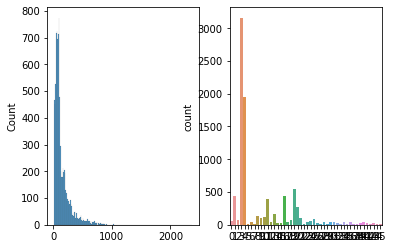

In [34]:
# 기사의 평균 단어 길이
len_sample = [len(sample) for sample in x_train] 
plt.subplot(121);sns.histplot(x = len_sample)
plt.subplot(122);sns.countplot(x=y_train)
print('뉴스 기사의 평균길이 :', np.mean(len_sample))

In [36]:
# 데이터 전처리 : 패딩
MAX_LEN = 128
x_train = preprocessing.sequence.pad_sequences(x_train, maxlen = MAX_LEN) # 평균보다 높으면 성능 낮음
x_test = preprocessing.sequence.pad_sequences(x_test, maxlen = MAX_LEN)

print('훈련 데이터 :', x_train.shape, y_train.shape)
print('테스트 데이터 :', x_test.shape, y_test.shape)

훈련 데이터 : (8982, 128) (8982,)
테스트 데이터 : (2246, 128) (2246,)


### | 임베딩 매트릭스 제작

```
! gdown https://drive.google.com/u/0/uc?id=1ams5_zp8NrfmbxSzTDCglRpAvjFGi5JY&export=download
! unzip  /content/glove.6B.zip
```


In [68]:
! gdown https://drive.google.com/uc?id=1SskmaqNEYmXSADf3opvqoova08078lJV&export=download

Downloading...
From: https://drive.google.com/uc?id=1SskmaqNEYmXSADf3opvqoova08078lJV
To: /content/glove.6B.100d.txt
100% 347M/347M [00:01<00:00, 278MB/s]


#### **단어-임베딩 딕셔너리**

```
embeddings_index = {}
f = open('glove.6B.100d.txt', encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
```

In [70]:
embeddings_index = {}
f = open('glove.6B.100d.txt', encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

#### **인덱싱-단어 딕셔너리**

In [37]:
word2index = tf.keras.datasets.reuters.get_word_index()
# print(word2index)
index2word = {}
for word, index in word2index.items():
  index2word[index + 3] = word # +3은 그냥 규칙
print(index2word)

{10999: 'mdbl', 16263: 'fawc', 12092: 'degussa', 8806: 'woods', 13799: 'hanging', 20675: 'localized', 20676: 'sation', 20678: 'chanthaburi', 11000: 'refunding', 8807: 'hermann', 20679: 'passsengers', 20680: 'stipulate', 8355: 'heublein', 20716: 'screaming', 16264: 'tcby', 188: 'four', 1645: 'grains', 20683: 'broiler', 12093: 'wooden', 1223: 'wednesday', 13800: 'highveld', 7596: 'duffour', 20684: '0053', 3917: 'elections', 2566: '270', 3554: '271', 5116: '272', 3555: '273', 3403: '274', 7978: 'rudman', 3404: '276', 3481: '277', 3635: '278', 4312: '279', 9384: 'dormancy', 7250: 'errors', 3089: 'deferred', 20686: 'sptnd', 8808: 'cooking', 20687: 'stratabit', 16265: 'designing', 20688: 'metalurgicos', 13801: 'databank', 20689: '300er', 20690: 'shocks', 7975: 'nawg', 20691: 'tnta', 20692: 'perforations', 2894: 'affiliates', 20693: '27p', 16266: 'ching', 598: 'china', 16267: 'wagyu', 3192: 'affiliated', 16268: 'chino', 16269: 'chinh', 20695: 'slickline', 13802: 'doldrums', 12095: 'kids', 303

In [38]:
for x in x_train[0]:
  if index2word.get(x) is not None : 
    print(index2word[x]) # 1000개 단어 외에는 생략됨

said
as
a
result
of
its
december
acquisition
of
co
it
expects
earnings
per
share
in
1987
of
1
15
to
1
30
dlrs
per
share
up
from
70
cts
in
1986
the
company
said
pretax
net
should
rise
to
nine
to
10
mln
dlrs
from
six
mln
dlrs
in
1986
and
revenues
to
19
to
22
mln
dlrs
from
12
5
mln
dlrs
it
said
cash
per
share
this
year
should
be
2
50
to
three
dlrs
reuter
3


#### **매트릭스 제작**

In [71]:
EMB_DIMS=100
embedding_matrix = np.zeros((MAX_FEATURES, EMB_DIMS))
print('임베딩 매트릭스 (W): ' , embedding_matrix.shape)
for i in range(1, MAX_FEATURES):
  idx=i+4
  word = index2word.get(idx)
  vec = embeddings_index.get(word)
  if vec is not None:
    embedding_matrix[i]=vec
    #print(i, idx, word, vec)

임베딩 매트릭스 (W):  (1000, 100)


### | 모델학습 1

이때까지 배운 레이어를 사용하여 모델을 구축하세요.

```
Embedding()
RNN()
LSTM()
GRU()
GlobalAveragePooling1D()
Dense()
```

Model: "model_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_37 (InputLayer)       [(None, 128)]             0         
                                                                 
 embedding_36 (Embedding)    (None, 128, 100)          100000    
                                                                 
 gru_55 (GRU)                (None, 128, 64)           31872     
                                                                 
 gru_56 (GRU)                (None, 128, 64)           24960     
                                                                 
 global_average_pooling1d_20  (None, 64)               0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_21 (Dense)            (None, 46)                2990      
                                                          

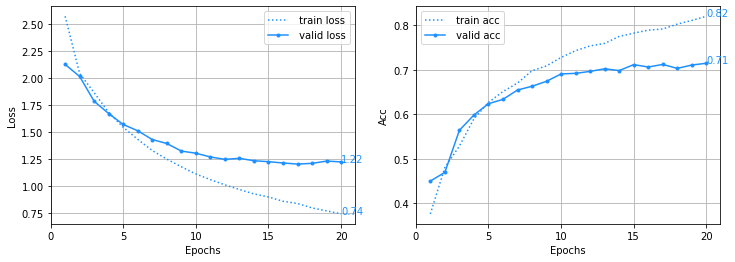

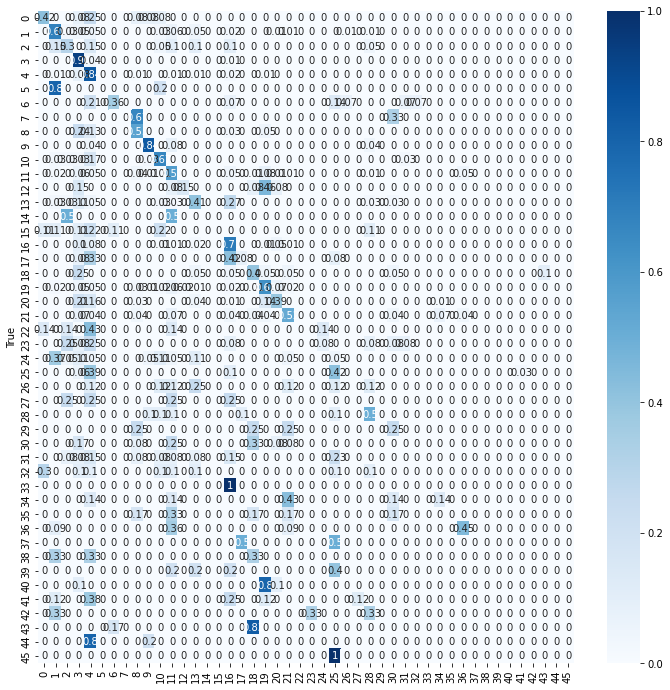

In [75]:
# 레이어 조합해서 정확도 72% 이상 만들기
EMB_DIMS = 100
x = layers.Input(shape = MAX_LEN)
y = layers.Embedding(MAX_FEATURES, EMB_DIMS)(x)
y = layers.GRU(64, return_sequences = True)(y)

y = layers.GRU(64, return_sequences = True)(y)
y = layers.GlobalAveragePooling1D()(y)
# GRU 3개, LSTM 2개는 성능이 좋지 않음.
# GRU, LSTM을 겹치는 것은 성능이 좋지 않음.

y = layers.Dense(46, activation = 'softmax')(y)
model = models.Model(x,y)

model.layers[1].set_weights([embedding_matrix])
model.compile(loss = 'sparse_categorical_crossentropy',
              optimizer = 'adam',
              metrics = ['acc'])
model.summary()

history = model.fit(x_train, y_train,
                    batch_size = 128,
                    epochs = 20,
                    validation_data = (x_test, y_test))
plot_lcurve([history], [''], ['dodgerblue'], x_itv = 5)
draw_cm(model, x_test, y_test)

### | 모델학습 2

![](https://www.researchgate.net/profile/Arvind-Mohan-3/publication/324769532/figure/fig2/AS:619510805561344@1524714294669/LSTM-and-BiLSTM-Architectures.png)

Model: "model_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_39 (InputLayer)       [(None, 128)]             0         
                                                                 
 embedding_38 (Embedding)    (None, 128, 100)          100000    
                                                                 
 bidirectional_2 (Bidirectio  (None, 128, 128)         63744     
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 128, 128)         74496     
 nal)                                                            
                                                                 
 global_average_pooling1d_22  (None, 128)              0         
  (GlobalAveragePooling1D)                                       
                                                          

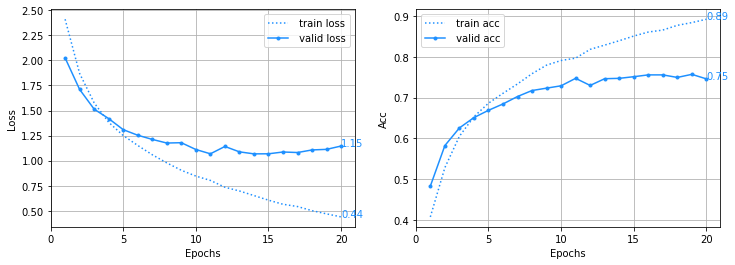

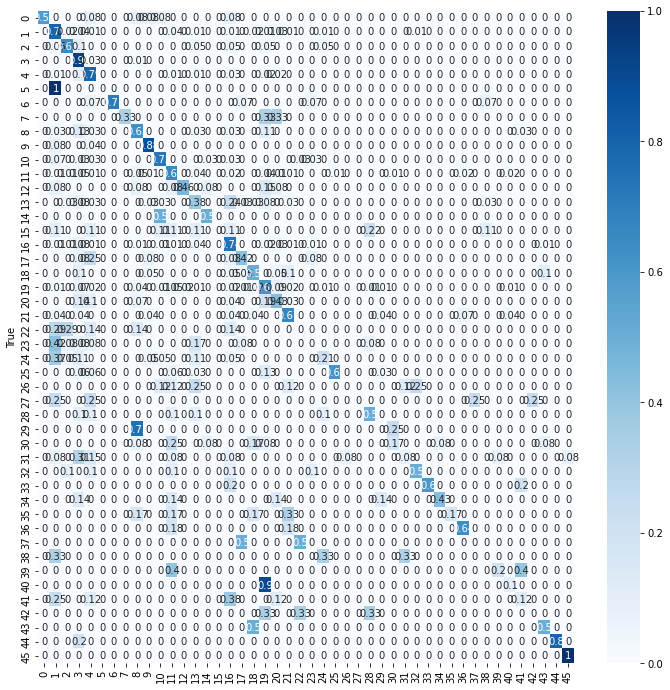

In [77]:
# 레이어 조합해서 정확도 72% 이상 만들기
EMB_DIMS = 100
x = layers.Input(shape = MAX_LEN)
y = layers.Embedding(MAX_FEATURES, EMB_DIMS)(x)

y = layers.Bidirectional( layers.GRU(64, return_sequences = True))(y)
y = layers.Bidirectional( layers.GRU(64, return_sequences = True))(y)

y = layers.GlobalAveragePooling1D()(y)
# GRU 3개, LSTM 2개는 성능이 좋지 않음.
# GRU, LSTM을 겹치는 것은 성능이 좋지 않음.

y = layers.Dense(46, activation = 'softmax')(y)
model = models.Model(x,y)

model.layers[1].set_weights([embedding_matrix])
model.compile(loss = 'sparse_categorical_crossentropy',
              optimizer = 'adam',
              metrics = ['acc'])
model.summary()

history = model.fit(x_train, y_train,
                    batch_size = 128,
                    epochs = 20,
                    validation_data = (x_test, y_test))
plot_lcurve([history], [''], ['dodgerblue'], x_itv = 5)
draw_cm(model, x_test, y_test)

## 스팀 리뷰 감성 분류
---

https://wikidocs.net/94748

```
# Colab에 Mecab 설치
!git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git
%cd Mecab-ko-for-Google-Colab
!bash install_mecab-ko_on_colab190912.sh
```

In [78]:
# Colab에 Mecab 설치
!git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git
%cd Mecab-ko-for-Google-Colab
!bash install_mecab-ko_on_colab190912.sh

Cloning into 'Mecab-ko-for-Google-Colab'...
remote: Enumerating objects: 115, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 115 (delta 11), reused 10 (delta 3), pack-reused 91
Receiving objects: 100% (115/115), 1.27 MiB | 24.09 MiB/s, done.
Resolving deltas: 100% (50/50), done.
/content/Mecab-ko-for-Google-Colab
Installing konlpy.....
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 19.4 MB 1.3 MB/s 
     |████████████████████████████████| 453 kB 58.7 MB/s 
Done
Installing mecab-0.996-ko-0.9.2.tar.gz.....
from https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
--2022-07-18 01:21:09--  https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
Resolving bitbucket.org (bitbucket.org)... 104.192.141.1, 2406:da00:ff00::22e9:9f55, 2406:da00:ff00::22c0:3470, ...
Connecting to bitbucket.org (b

In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
from collections import Counter
from konlpy.tag import Mecab
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [80]:
# 데이터 로드하기
urllib.request.urlretrieve("https://raw.githubusercontent.com/bab2min/corpus/master/sentiment/steam.txt", 
                           filename="steam.txt")

('steam.txt', <http.client.HTTPMessage at 0x7fd0885ac690>)

In [82]:
# 데이터에 열 제목이 없기에 임의로 label과 reviews 추가
total_data = pd.read_table('steam.txt', names=['label', 'reviews'])
print('전체 리뷰 개수 :',len(total_data)) # 전체 리뷰 개수 출력
total_data[:5]

전체 리뷰 개수 : 100000


,label,reviews
0,0,노래가 너무 적음
1,0,"돌겠네 진짜. 황숙아, 어크 공장 그만 돌려라. 죽는다."
2,1,막노동 체험판 막노동 하는사람인데 장비를 내가 사야돼 뭐지
3,1,차악!차악!!차악!!! 정말 이래서 왕국을 되찾을 수 있는거야??
4,1,시간 때우기에 좋음.. 도전과제는 50시간이면 다 깰 수 있어요


In [83]:
total_data['reviews'].nunique(), total_data['label'].nunique() # 중복 제외 샘플 수

(99892, 2)

In [84]:
# 만 개에서 중복이 있는 것을 확인. 중복 제거 한 후 NULL값 확인
total_data.drop_duplicates(subset=['reviews'], inplace=True) # reviews 열에서 중복인 내용이 있다면 중복 제거
print('총 샘플의 수 :',len(total_data))

print(total_data.isnull().values.any())


총 샘플의 수 : 99892
False


In [85]:
train_data, test_data = train_test_split(total_data, test_size = 0.25, random_state = 42)
print('훈련용 리뷰의 개수 :', len(train_data))
print('테스트용 리뷰의 개수 :', len(test_data))

훈련용 리뷰의 개수 : 74919
테스트용 리뷰의 개수 : 24973


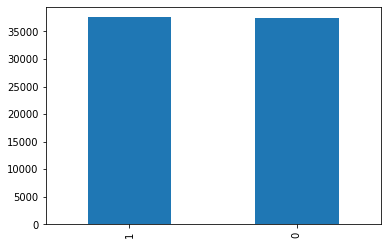

In [86]:
train_data['label'].value_counts().plot(kind = 'bar')


In [87]:
print(train_data.groupby('label').size().reset_index(name = 'count'))


   label  count
0      0  37376
1      1  37543


In [88]:
# 한글과 공백을 제외하고 모두 제거
train_data['reviews'] = train_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
train_data['reviews'].replace('', np.nan, inplace=True)
print(train_data.isnull().sum())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


label      0
reviews    0
dtype: int64


In [89]:
test_data.drop_duplicates(subset = ['reviews'], inplace=True) # 중복 제거
test_data['reviews'] = test_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
test_data['reviews'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test_data = test_data.dropna(how='any') # Null 값 제거
print('전처리 후 테스트용 샘플의 개수 :',len(test_data))

전처리 후 테스트용 샘플의 개수 : 24973


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


In [90]:
# 불용어 지정
stopwords = ['도', '는', '다', '의', '가', '이', '은', '한', '에', '하', '고', '을', '를', '인', '듯', '과', '와', '네', '들', '듯', '지', '임', '게', '만', '게임', '겜', '되', '음', '면']

In [91]:
mecab = Mecab() 

train_data['tokenized'] = train_data['reviews'].apply(mecab.morphs)
train_data['tokenized'] = train_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])
test_data['tokenized'] = test_data['reviews'].apply(mecab.morphs)
test_data['tokenized'] = test_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])

In [94]:
# 단어의 빈도수 확인
negative_words = np.hstack(train_data[train_data.label == 0]['tokenized'].values)
positive_words = np.hstack(train_data[train_data.label == 1]['tokenized'].values)

# 부정적 리뷰
negative_word_count = Counter(negative_words)
print(negative_word_count.most_common(20))
# 긍정적 리뷰
positive_word_count = Counter(positive_words)
print(positive_word_count.most_common(20))

[('안', 8129), ('없', 7141), ('는데', 5786), ('있', 5692), ('같', 4247), ('로', 4083), ('할', 3920), ('거', 3902), ('나', 3805), ('해', 3653), ('너무', 3522), ('으로', 3351), ('기', 3348), ('했', 3265), ('어', 3143), ('보', 2987), ('습니다', 2962), ('것', 2935), ('지만', 2911), ('좋', 2899)]
[('있', 9987), ('좋', 6542), ('습니다', 5179), ('재밌', 4997), ('할', 4838), ('지만', 4809), ('해', 4354), ('없', 4145), ('보', 3907), ('으로', 3900), ('로', 3879), ('수', 3835), ('는데', 3825), ('기', 3592), ('안', 3368), ('것', 3362), ('같', 3356), ('네요', 3189), ('어', 3112), ('나', 3055)]


긍정 리뷰의 평균 길이 : 14.948459100231734
부정 리뷰의 평균 길이 : 15.284193065068493


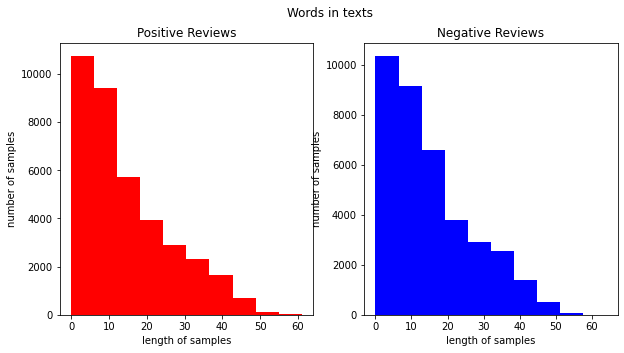

In [95]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
text_len = train_data[train_data['label']==1]['tokenized'].map(lambda x: len(x))
ax1.hist(text_len, color='red')
ax1.set_title('Positive Reviews')
ax1.set_xlabel('length of samples')
ax1.set_ylabel('number of samples')
print('긍정 리뷰의 평균 길이 :', np.mean(text_len))

text_len = train_data[train_data['label']==0]['tokenized'].map(lambda x: len(x))
ax2.hist(text_len, color='blue')
ax2.set_title('Negative Reviews')
fig.suptitle('Words in texts')
ax2.set_xlabel('length of samples')
ax2.set_ylabel('number of samples')
print('부정 리뷰의 평균 길이 :', np.mean(text_len))
plt.show()

In [96]:
X_train = train_data['tokenized'].values
y_train = train_data['label'].values
X_test= test_data['tokenized'].values
y_test = test_data['label'].values

In [97]:
# 정수 인코딩 -> 인덱싱
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [98]:
# 등장 횟수가 1회인 단어들은 배제하기 위해 비중 확인

threshold = 2
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 32817
등장 빈도가 1번 이하인 희귀 단어의 수: 13878
단어 집합에서 희귀 단어의 비율: 42.28905750068562
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 1.2254607619437832


In [99]:
# 전체 단어 개수 중 빈도수 2이하인 단어 개수는 제거.
# 0번 패딩 토큰과 1번 OOV 토큰을 고려하여 +2

vocab_size = total_cnt - rare_cnt + 2
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 18941


In [100]:
tokenizer = Tokenizer(vocab_size, oov_token = 'OOV') 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

리뷰의 최대 길이 : 64
리뷰의 평균 길이 : 15.115951894712957


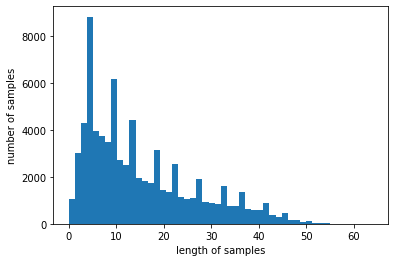

In [101]:
print('리뷰의 최대 길이 :',max(len(review) for review in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(review) for review in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [103]:
# 패딩할 기준을 잡기 위해 -> max_len에 적절한 값이 무엇인지 확인하기 위해
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

In [105]:
max_len = 60
below_threshold_len(max_len, X_train) 
# 60일 때 99.99%가 샘플 보존

전체 샘플 중 길이가 60 이하인 샘플의 비율: 99.99599567532935


In [106]:
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

In [107]:
import re
from tensorflow.keras.layers import Embedding, Dense, LSTM, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(Bidirectional(LSTM(hidden_units))) # Bidirectional LSTM을 사용
model.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=256, validation_split=0.2)

Epoch 1/15
234/235 [============================>.] - ETA: 0s - loss: 0.5261 - acc: 0.7444
Epoch 1: val_acc improved from -inf to 0.77896, saving model to best_model.h5
235/235 [==============================] - 9s 23ms/step - loss: 0.5260 - acc: 0.7444 - val_loss: 0.4738 - val_acc: 0.7790
Epoch 2/15
234/235 [============================>.] - ETA: 0s - loss: 0.4315 - acc: 0.8038
Epoch 2: val_acc improved from 0.77896 to 0.78711, saving model to best_model.h5
235/235 [==============================] - 4s 18ms/step - loss: 0.4316 - acc: 0.8038 - val_loss: 0.4606 - val_acc: 0.7871
Epoch 3/15
235/235 [==============================] - ETA: 0s - loss: 0.4049 - acc: 0.8196
Epoch 3: val_acc improved from 0.78711 to 0.79004, saving model to best_model.h5
235/235 [==============================] - 4s 18ms/step - loss: 0.4049 - acc: 0.8196 - val_loss: 0.4552 - val_acc: 0.7900
Epoch 4/15
232/235 [============================>.] - ETA: 0s - loss: 0.3831 - acc: 0.8309
Epoch 4: val_acc did not impro

In [110]:
loaded_model = load_model('best_model.h5')
print("테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

781/781 [==============================] - 19s 6ms/step - loss: 0.4550 - acc: 0.7891
테스트 정확도: 0.7891


In [111]:
# 예측하기 위한 함수. 문장을 넣으면 분류
def sentiment_predict(new_sentence):
  new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
  new_sentence = mecab.morphs(new_sentence) # 토큰화
  new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
  encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
  pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
  score = float(loaded_model.predict(pad_new)) # 예측
  if(score > 0.5):
    print("{:.2f}% 확률로 긍정 리뷰입니다.".format(score * 100))
  else:
    print("{:.2f}% 확률로 부정 리뷰입니다.".format((1 - score) * 100))

In [112]:
sentiment_predict('노잼 ..완전 재미 없음 ㅉㅉ')

92.27% 확률로 부정 리뷰입니다.
